# Exploring Community Engagement with StackExchange Fora

## Table of Contents

* Abstract
* Introduction
* Datasets: StackExchange
* Distributed Computing Technology
* Conclusion
* References
* Appendix

## Abstract

Developing high-quality questions and procuring answers to these questions is not only fundamental to learning and information gathering, but to scientific and progress as a whole. Online question-answer communities and fora have given internet-users the unprecendented ability of presenting questions to the world, and while much attention has been given to finding the right answers (ask Google), relatively little attention has been dedicated to how we can improve questions. 

Having users produce relevant, legible and previously-researched questions is particularly valuable in communities where expert resources are often scarce. One way in which to promote this would be to **predict a question's quality/community engagement so that users can be nudged to improve aspects of their questions before adding demand to the community.** With this end-goal in mind, this analysis explores a group of **large online question-answer communities**... **critiques, validates and extends the methodology in previous research that has been focused on questions in question-answer communities.** By harnessing the capability of distributed cloud computing, I am able to analyse datasets much larger than what is capable by a single, commercial laptop.

## Introduction

The aim of the project is to being an exploration of how the online question-answer communities interact with questions and how users can be nudged to improve questions before adding demand to expert resources in a community. 

This work follows a line of research aimed at predicting question quality - more specifically, my analysis will build on methodology developed in @Ravi2014. **Before Ravi however**, Research has looked at question quality using Yahoo! Answers (@Agichtein2008, @Bian2009, and @Li2012),

The ability to use cloud computing is cool because...



The layout of the analysis is as follows. Firstly and secondly I give a brief discussion of the distributed computing technologies and datasets used. This is followed by an explanation of setup code and the specific architecture of the computing capabilities I used. I then query and perform Exploratory Data Analysis on the chosen datasets. **I consequently build a model to predict and predict on the datasets.** Lastly I conclude with a discussion of the results and recommend further research.

## Distributed Computing Technologies

### SQL

A discussion of more advanced distributed computing techniques necessetates at least an introduction to Structured Query Languages

### Apache Spark

Now you can use PySpark

You can invoke SparkContext as `sc`. `pyspark.SparkContext` is the main entry point for Spark functionality.

`pyspark.RDD` is the novel concept of Resilient Distributed Dataset (RDD) which is the basic abstraction in Spark.

The design for RDDs was intended to ensure fault-tolerance, distribution across **....** and in-memory computing.



You are also able to work with streaming data with `pyspark.streaming.StreamingContext` being the main entry point for the Spark Streaming capability.

`pyspark.streaming.DStream` is a Discretized Stream (DStream) which is the basic abstraction in Spark Streaming.

For the use of DataFrames and SQL, `pyspark.sql.SparkSession` is used where `pyspark.sql.DataFrame` serves as a distributed collection of data that grouped into named columns.

Since we will not be working with streaming data, I will mostly be using `pyspark.sql.DataFrame` objects, the user guide for which can be found [here](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#).




sqlContext is also automatically created in the PySpark session.

### Comparison to other BigData tech

Although a rule of thumb is that Spark is best-suited for real-time or streaming data processing where a large amount of RAM is accessible and Hadoop is more suitable for batch processing using commodity hardware, I chose to use Spark owing to the ease of use of PySpark and the SQL like API, **over some** imperative programming like Mapreduce.

### Google Cloud Platform

Specifically the Compute Engine on the Google Cloud Platform (GCP) gives the ability to rent different types of masters/workers with CPU values of 1, 2, 4, 8, 16, 32, 64 and 96 with the option of having lower memory per Compute Instance (highcpu) or higher (highmem).

## Datasets: StackExchange Family

[StackExchange](https://stackexchange.com/sites#traffic) is a group of over 170 dedicated question-answer websites covering topics ranging from vegetarianism to robotics to science-fiction world building. The largest forum is programming site StackOverflow, now home to more than 10 million registered users and 18 million questions at the time of writing.

The data across all StackExchange sites are publicly available in XML format (zipped by 7-zip with bzip2 compression) at [archive.org](https://archive.org/download/stackexchange) and are regularly updated (the last update being 4 March 2019). For each site, the following files are available:

* `PostHistory.xml`: A history of the versions of each question and answer posted (questions can be edited)
* `Posts.xml`: The final, up to date version of each question and answer posted
* `Users.xml`: Data on registered users 
* `Votes.xml`: Data on different votes cast (moderator-related, offensive, spam, votes to close, delete etc.)
* `Comments.xml`: The final, up to date version of each comment posted
* `Badges.xml`: Log of when badges (an incentive mechanism) are awarded to users for specific achievements
* `PostLinks.xml`: Connects posts marked as linked or duplicated
* `Tags.xml`: Data on the tags put forth with each question posted

As this is an initial analysis, I will only be using the `Posts.xml` data for each forum. In this file, the following variables are recorded per post:

* `Id`: A chronological post identity variable
* `PostTypeId`: Mainly an indicator of whether the post is an question (==1) or an answer (==2)
* `ParentId`: An indicator of which question and answer belongs to (only answers)
* `AcceptedAnswerId`: An indicator of which answer the original question poster selected as accepted (only questions)
* `CreationDate`: A date variable relating to when the post was made
* `Score`: The difference between up-votes and down-votes for posts
* `ViewCount`: The number of times that a post has been viewed by registered and non-registered users alike
* `Body`: The main post content
* `OwnerUserId`: A identity variable for the post owner
* `LastEditorUserId`: A identity number for the last registered user that edited the post
* `LastEditDate`: A date variable relating to when the post was last edited
* `LastActivityDate`: A date variable relating to when last there was activity on the post
* `Title`: The post title for questions only
* `Tags`: The collection of tags linked to a question
* `AnswerCount`: The number of answers that a question receives (questions only)
* `CommentCount`: The number of comments that a post receives
* `FavoriteCount`: The number of times that users have favourited a question (questions only)
* `ClosedDate`: A boolean relating to whether a question has been closed or not (questions only)

**Note:** The word "post" above refers to both questions and answers.

**Other aspects of the data**

It is worth mentioning the following:

* Not everyone who views a question (and thus adds to the `ViewCount`) can vote since you have to be a registered user to vote (the sites are open to the public) and you also need a certain amount of reputation to vote
* A [reputation](https://meta.stackexchange.com/questions/7237/how-does-reputation-work) level of 15 allows you to up-vote, whereas a level of 125 allows you to down-vote, thus the distribution of the `Score` variable is highly negatively skewed (more highly-scored questions and answers)
* Only a handful of the above variables will be used in this initial analysis

**Downloading the data**

The datasets were downloaded with the following bash script, run when the GCP cluster is created:

```bash
## install htop to monitor CPUs later
sudo apt-get install htop

## install unzipper
sudo apt-get install --yes p7zip-full

## create folder and datasets array (separate approach for stackoverflow.com-Posts.7z)
mkdir datasets && cd datasets

declare -a arr=(
"askubuntu.com"
"codegolf.stackexchange.com"
"codereview.stackexchange.com"
"es.stackoverflow.com"
"math.stackexchange.com"
"physics.stackexchange.com"
"ru.stackoverflow.com"
"stackoverflow.com-Posts"
"superuser.com"
"unix.stackexchange.com"
)

## loop downloading, unzipping and extracting all XML data
for i in "${arr[@]}"
do
   mkdir "$i" && cd "$i"
   wget https://archive.org/download/stackexchange/"$i".7z
   p7zip -d "$i".7z
   find . -type f ! -name 'Posts.xml' -delete # delete everything except Posts.xml
   cd ..
   echo "On to next dataset!"
done

## rename folders for ease of import later
mv stackoverflow.com-Posts stackoverflow.stackexchange.com
mv superuser.com superuser.stackexchange.com
mv askubuntu.com askubuntu.stackexchange.com
mv ru.stackoverflow.com rus_stackoverflow.stackexchange.com
mv es.stackoverflow.com es_stackoverflow.stackexchange.com

cd

## copy datasets folder over to bucket
gsutil cp -r datasets gs://bucket-brad-project/datasets/large-datasets
```

**Cluster and Environment Setup**

I used the following code entered into my terminal to spin up a custom dataproc cluster on GCP:

```bash
## set project beforehand
gcloud config list
export PROJECT="stack-exchange-project"
gcloud config set project ${PROJECT}

## set variables beforehand
export NUM_WORKERS="2"
export BUCKET="bucket-brad-project"
export CLUSTER="cluster-brad"

## spin up cluster
gcloud dataproc clusters create ${CLUSTER} \
--properties=^#^spark:spark.jars.packages=com.databricks:spark-xml_2.11:0.4.1 \
 --subnet default --zone europe-west2-a --master-machine-type n1-highmem-96 \
 --master-boot-disk-size 500 --num-workers=${NUM_WORKERS} --worker-machine-type n1-highmem-16 \
 --worker-boot-disk-size 500 --image-version 1.3-deb9 --project=${PROJECT} --bucket=${BUCKET} \
 --initialization-actions 'gs://dataproc-initialization-actions/jupyter/jupyter.sh',\
'gs://dataproc-initialization-actions/python/pip-install.sh','gs://bucket-brad-project/my-actions.sh' \
--metadata 'PIP_PACKAGES=sklearn nltk pandas'

## connect to jupyter notebook
export PORT=8123
export ZONE="europe-west2-a"
export HOSTNAME=cluster-brad-m

gcloud compute ssh ${HOSTNAME} \
    --project=${PROJECT} --zone=${ZONE}  -- \
    -D ${PORT} -N &

"/Applications/Google Chrome.app/Contents/MacOS/Google Chrome" \
      --proxy-server="socks5://localhost:${PORT}" \
      --user-data-dir=/tmp/${HOSTNAME}
```
```bash
## delete clusters after use
gcloud dataproc clusters delete cluster-brad
```

**Note:** The analysis required substantial testing and optimising in the interest of increasing speed and thus I had to request increases in my computing quotas from Google.

---

# Analysis

## Importing and Setup

In [5]:
## testing printing output from console
import subprocess
cmd = [ 'echo', '"Welcome to my notebook"' ]
output = subprocess.Popen( cmd, stdout=subprocess.PIPE ).communicate()[0]
print(output)

b'"Welcome to my notebook"\n'


In [6]:
## use com.databricks package specified when spinning up cluster
import os ## restart kernel
#os._exit(00)
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.4.1 pyspark-shell'

In [7]:
## check default number of partitions
sc.defaultParallelism

8

In [9]:
## import standard libraries
import re
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

## import pyspark elements
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
from pyspark.sql.functions import col, lit, when
from pyspark.sql import Row

## import natural language processing elements
import nltk
#nltk.download('all') # uncomment first run as admin check
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer()

## function to tokenise and lemmatise
def get_tokens(line):
    ###
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuations from each word
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # lemmatizing the words, see https://en.wikipedia.org/wiki/Lemmatisation
    words = [lmtzr.lemmatize(w) for w in words]
    return (words)

## set checkpoint directory
sc.setCheckpointDir("gs://bucket-brad-project/tmp/")

## Loading Data

In [14]:
## choose datasets to compare
data_array = [
"codegolf",
"codereview",
"es_stackoverflow",
"physics",
"unix"
]

Owing to difficulties in processing speeds that will be detailed later, I chose to analyse only the above datasets, information on which is displayed below:

| Fora | Registered Users | Questions | Answers | Posts.xml Size | Description |
| --- | --- | --- | --- | --- | --- |
| codegolf | 68k | 11k | 137k | 272.74 MB | Programming puzzles |
| codereview | 171k | 59k | 94k | 596.56  MB | Peer programmer code reviews |
| es_stackoverflow | 115k | 89k | 100k | 420.67 MB | Spanish StackOverflow |
| physics | 167k | 137k | 202k | 509.59 MB | Physics related |
| unix | 311k | 159k | 242k | 577.06 MB | Linux, FreeBSD and other Un*x-like operating systems

In [15]:
## point to right directory
fpath = 'gs://bucket-brad-project/datasets/large-datasets/'

## function to extract data from xml files
def load_all_xml(table_name):
    # create dataframe list skeleton
    dfs = {}
    xml_name = table_name.capitalize()
    for i in data_array:
        table = sqlContext.read.format('com.databricks.spark.xml').options(rowTag=table_name).load(fpath+i+'.stackexchange.com/'+xml_name+'.xml')
        rdd_table = table.rdd.flatMap(lambda x: x).flatMap(lambda x: x).repartition(96) # key step
        # assign dataframe to list entry
        dfs[i] = sqlContext.createDataFrame(rdd_table, table.schema.fields[0].dataType.elementType)
        dfs[i].createOrReplaceTempView(table_name)
    return dfs

In [16]:
## display architecture (must find workers as well)
import multiprocessing
print("Number of CPUs master node:", multiprocessing.cpu_count())

## testing printing output from console
import subprocess
cmd = [ 'grep', 'MemTotal', '/proc/meminfo' ]
output = subprocess.Popen( cmd, stdout=subprocess.PIPE ).communicate()[0]
print(output)

Number of CPUs master node: 96
b'MemTotal:       643995876 kB\n'


Much time was spent testing out cluster architectures since just the loading-in of the smallest of the 10 datasets was taking a substantial amount of time. Eventually due to time and GCP budget constraints, despite only exploring the 5 smallest datasets downloaded (a total of just over 2gb of data) I decided scale vertically as opposed to horizontally, resulting in a high-memory master node with 96 CPUs.

In [39]:
## start time
t0 = time.time()
print("Start time:", datetime.now().time())

## extract all datasets and store in list of dataframes
posts_dfs = load_all_xml("posts")

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") 

Start time: 09:29:12.115888
Time taken: 17 minutes.


Examples of the times taken to read in only the respective forums are displayed below (the read-in times are proportional to computation time later in the analysis):

| Master Node | Workers | Read-In Time | Fora |
| --- | --- | --- | --- |
| n1-highcpu-32 | 4 x n1-highcpu-8 | > 7 min | codereview |
| n1-highcpu-32 | 7 x n1-standard-4 | 7 min | codereview |
| n1-highmem-32 | 2 x n1-standard-8 | 4 min | codereview |
| n1-highmem-96 | 2 x n1-highmem-96 | 4 min | codereview |
| n1-standard-32 | 2 x n1-standard-4 | 4 min | codereview |
| n1-highcpu-32 | 2 x n1-standard-4 | 4 min | codereview |
| n1-standard-64 | 2 x n1-standard-4 | 4 min | codereview |
| n1-highmem-32 | 2 x n1-standard-4 | 4 min | codereview |
| n1-highmem-32 | 2 x n1-highmem-4 | failed | es_stackoverflow, codereview, physics, unix |
| n1-highmem-96 | 2 x n1-highmem-16 | 12 min | codereview, physics, unix |
| n1-highmem-32 | 2 x n1-highmem-4 | 11 min | codereview, physics, unix |
| n1-highmem-96 | 0  | 17 min | es_stackoverflow, codegolf, codereview, physics, unix |


From the table we can see that increasing the workers doesn't appear to increase speed, increasing the memory helps slightly and increasing the CPUs of the master node apparently matters the most (although the gain in speed for using so many CPUs leaves much to be desired). While this may indicate resource bottlenecking on the master CPUs, a much more likely explanation is that the full capacity of the cores of the master and workers is not being used when issuing PySpark commands, and htop provides evidence for this:

[PIC OF HTOP]

This is a common theme throughout the analysis with PySpark commands failing if there aren't enough cores on the master worker. Initially it was thought that this was due to the original data being stored in XML format [as this appears to be an issue in some cases](https://community.hortonworks.com/questions/78024/comdatabrickssparkxml-parsing-xml-takes-a-very-lon.html), but my hypothesis is that the underlying Spark installation beneath PySpark is having trouble using the cores across the master and workers effectively, resulting in very high computation times for basic queries on very small datasets. While much was tried to address this problem, it remained throughout the analysis and hence why not all 10 largest StackExchange datasets (let alone 20) were analysed. Nevertheless, this notebook allows for the reproducibility of the analysis with larger datasets if this particular obstacle is overcome.

In [8]:
## spark commands to ascertain reason for slow computation speed
#sc._conf.getAll()
#sc.stop()
#sc = SparkContext("local[*]", "Test")
#sc._conf.getAll()

**A note on the data**

An interesting aspect of the data is that while it is initially in raw XML format which is considered **semi-structured** since it contains tags/markers to enforce hierarchy of entries, I read-in the data to a `pyspark.sql.DataFrame` which has a schema and is thus **structured**. The final `Body` variable I work with is completely **unstructured** since as text it is not organised in any manner.

**Testing to see if repartitioning data speeds up analysis**

In [41]:
## start time
t0 = time.time()
print("Start time:", datetime.now().time())

## count rows of first dataset
print(posts_dfs["codegolf"].count())
    
## end time
T = time.time() - t0;
print("Time taken:", T/60, "minutes.") 

Start time: 09:46:37.584317
145539
Time taken: 3.021807797749837 minutes.


In [46]:
## repartition
for i in data_array:
    posts_dfs[i] = posts_dfs[i].repartition(384)
    print(posts_dfs[i].rdd.getNumPartitions())

384
384
384
384
384


In [47]:
## start time
t0 = time.time()
print("Start time:", datetime.now().time())

## count rows of first dataset
print(posts_dfs["codegolf"].count())
    
## end time
T = time.time() - t0;
print("Time taken:", T/60, "minutes.") 

Start time: 09:57:32.823280
145539
Time taken: 3.1331292430559796 minutes.


After trying a number of partitions from 4 to 384, it appears that this has little to no effect on computation speed. Again, the issue of only a few cores being used is present:

[PIC 2 OF HTOP]

# Exploratory Data Analysis

In [48]:
# print type of posts_dfs
print(type(posts_dfs))
print('\n')

# print type of first dataframe
print(type(posts_dfs["codereview"]))
print('\n')

# schema of first dataframe
posts_dfs["codereview"].printSchema()

<class 'dict'>


<class 'pyspark.sql.dataframe.DataFrame'>


root
 |-- _AcceptedAnswerId: long (nullable = true)
 |-- _AnswerCount: long (nullable = true)
 |-- _Body: string (nullable = true)
 |-- _ClosedDate: string (nullable = true)
 |-- _CommentCount: long (nullable = true)
 |-- _CommunityOwnedDate: string (nullable = true)
 |-- _CreationDate: string (nullable = true)
 |-- _FavoriteCount: long (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _LastActivityDate: string (nullable = true)
 |-- _LastEditDate: string (nullable = true)
 |-- _LastEditorDisplayName: string (nullable = true)
 |-- _LastEditorUserId: long (nullable = true)
 |-- _OwnerDisplayName: string (nullable = true)
 |-- _OwnerUserId: long (nullable = true)
 |-- _ParentId: long (nullable = true)
 |-- _PostTypeId: long (nullable = true)
 |-- _Score: long (nullable = true)
 |-- _Tags: string (nullable = true)
 |-- _Title: string (nullable = true)
 |-- _VALUE: string (nullable = true)
 |-- _ViewCount: long (nullable = 

To save computation time, we drop columns we don't need:

In [50]:
## start time
t0 = time.time()
print("Start time:", datetime.now().time())

for i in data_array:
    posts_dfs[i] = posts_dfs[i].select('_AnswerCount', '_Body', '_CommentCount', '_PostTypeId', '_Score', '_ViewCount')
    
## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") 

Start time: 10:02:51.643357
Time taken: 0 minutes.


We can see how PySpark commands are lazily evaluated since the above command is almost instantaneous.

In [52]:
## garbage collector to speed up computation
import gc
collected = gc.collect()
print("Garbage collector: collected %d objects." % collected)

Garbage collector: collected 473 objects.


In [54]:
## start time
t0 = time.time()
print(datetime.now().time())

for i in data_array:
    print("\n------------------\n", i, "\n------------------\n")
    print(posts_dfs[i].select('_AnswerCount', '_CommentCount', '_PostTypeId', '_Score', '_ViewCount').describe().show())
    
## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 36 minutes all-5

10:10:21.740725

------------------
 codegolf 
------------------

+-------+------------------+-----------------+------------------+-----------------+------------------+
|summary|      _AnswerCount|    _CommentCount|       _PostTypeId|           _Score|        _ViewCount|
+-------+------------------+-----------------+------------------+-----------------+------------------+
|  count|             10389|           145539|            145539|           145539|             10389|
|   mean|12.940128982577727|1.915184246147081|1.9412322470265702|5.129518548292897|2338.6605063047455|
| stddev| 20.86264087761769|3.375810436163644|0.3194763857462286| 13.6708923054352|7544.9500355821165|
|    min|                 0|                0|                 1|              -35|                17|
|    max|               733|               94|                 7|             1277|            433789|
+-------+------------------+-----------------+------------------+-----------------+------------------+

None


10:46:30.316033
Time taken: 32 minutes.


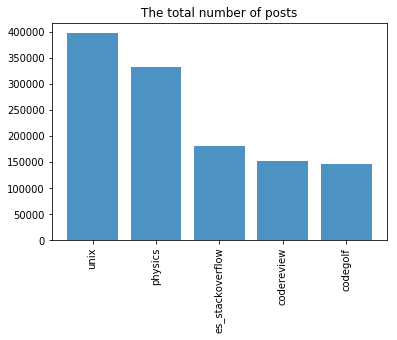

In [55]:
## empty dictionary of df skeleton
plot_data = {}

## start time
t0 = time.time()
print(datetime.now().time())

## total number of posts of fora
for i in data_array:
    plot_data[i] = posts_dfs[i].count()

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") 
# hm96;2xhm16 - 24 minutes codereview, physics, unix
# hm96 - 32 minutes all-5
    
## bar plot of post counts in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('The total number of posts')
plt.show()

11:21:32.118604
Time taken: 30 minutes.


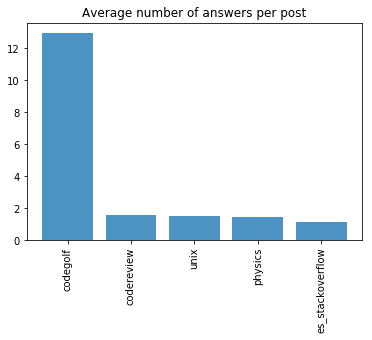

In [56]:
## empty dictionary of df skeleton
plot_data = {}

## start time
t0 = time.time()
print(datetime.now().time())

## total number of answers per post of fora
for i in data_array:
    plot_data[i] = posts_dfs[i].groupBy().avg('_AnswerCount').collect()[0][0]

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.")
# hm96;2xhm16 - 24 minutes codereview, physics, unix
# hm96 - 30 minutes all-5

## bar plot of answers per post in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('Average number of answers per post')
plt.show()

11:51:50.519251
Time taken: 28 minutes.


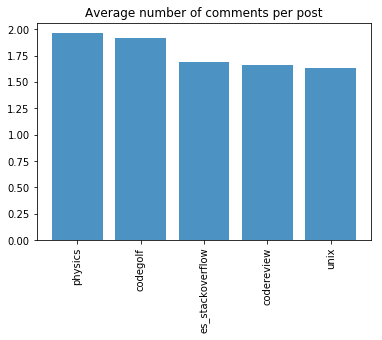

In [57]:
## empty dictionary of df skeleton
plot_data = {}

## start time
t0 = time.time()
print(datetime.now().time())

## total number of comments per post of fora
for i in data_array:
    plot_data[i] = posts_dfs[i].groupBy().avg('_CommentCount').collect()[0][0]

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.")
# hm96;2xhm16 - 24 minutes codereview, physics, unix
# hm96 - 28 minutes all-5


## bar plot of comments per post in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('Average number of comments per post')
plt.show()

12:20:03.116557
Time taken: 29 minutes.


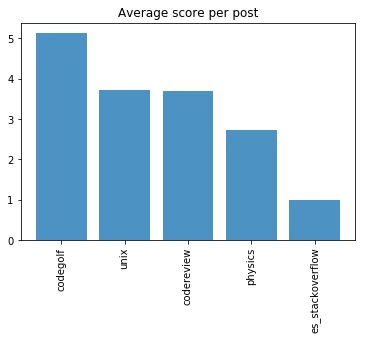

In [58]:
## empty dictionary of df skeleton
plot_data = {}

## start time
t0 = time.time()
print(datetime.now().time())

## average score per post across fora
for i in data_array:
    plot_data[i] = posts_dfs[i].groupBy().avg('_Score').collect()[0][0]

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.")
# hm96;2xhm16 - 23 minutes codereview, physics, unix
# hm96 - 29 minutes all-5
    
## bar plot of score per post in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('Average score per post')
plt.show()

12:48:58.930877
Time taken: 29 minutes.


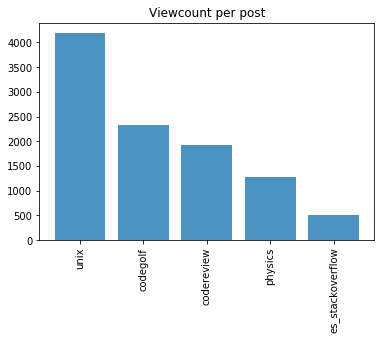

In [59]:
## empty dictionary of df skeleton
plot_data = {}

## start time
t0 = time.time()
print(datetime.now().time())

## average viewcount per post across fora
for i in data_array:
    plot_data[i] = posts_dfs[i].groupBy().avg('_ViewCount').collect()[0][0]

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.")
# hm96;2xhm16 - 24 minutes codereview, physics, unix
# hm96 - 29 minutes all-5
    
## bar plot of viewcount per post in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('Viewcount per post')
plt.show()

13:18:16.806485
Time taken: 29 minutes.


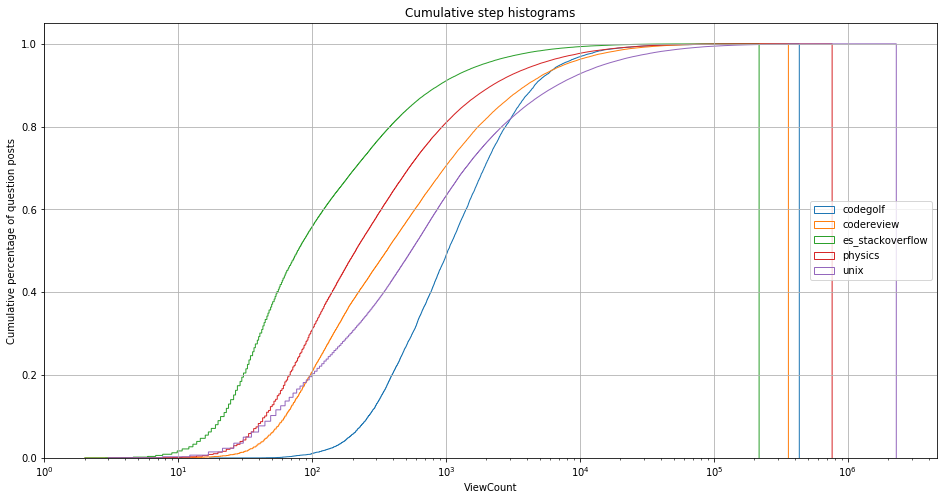

In [60]:
## start time
t0 = time.time()
print(datetime.now().time())

## create plot data for cumulative viewcount
plot_data = {}
for i in data_array:
    plot_data[i] = posts_dfs[i].select('_ViewCount').rdd.flatMap(lambda x: x).collect()
    plot_data[i] = [x for x in plot_data[i] if x is not None]
    
## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.")
# hm96;2xhm16 - 23 minutes codereview, physics, unix
# hm96 - 29 minutes all-5

## plot cumulative distribution of viewcount across fora
n_bins = 500000
fig, ax = plt.subplots(figsize=(16, 8))
for i in data_array:
    n, bins, patches = ax.hist(plot_data[i], n_bins, density=True, histtype='step',
                               cumulative=True, label=i)
ax.grid(True)
ax.set_xscale('log')
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('ViewCount')
ax.set_ylabel('Cumulative percentage of question posts')
plt.show()

# Natural Language Processing

In [ ]:
## garbage collector to speed up computation
import gc
collected = gc.collect()
print("Garbage collector: collected %d objects." % collected)

In [61]:
## extract Body from fora
body_data = {}
for i in data_array:
    body_data[i] = posts_dfs[i].select("_Body").rdd.flatMap(lambda r: r)

In [69]:
## start time
t0 = time.time()
print(datetime.now().time())

## look at first post from physics
print(body_data['physics'].take(1))

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 8 minutes all-5

14:02:10.136339
['<p>We live in the age of measurements and observations and specific mathematical theories that fit measurements and observations beyond any doubt.</p>\n\n<p>Photons are <a href="https://en.wikipedia.org/wiki/Elementary_particle" rel="nofollow">elementary particles.</a> . They have zero mass, and other characteristics which separate them from other elementary particles .  </p>\n\n<blockquote>\n  <p>Can photons lose a small amount of energy over time when traveling large distances due to either weak interactions with magnetic fields (Faraday Effect) </p>\n</blockquote>\n\n<p>This is an electromagnetic vertex for a photon, the faraday effect is for the emergent light beam from innumerable photons. </p>\n\n<blockquote>\n  <p>or due to the way all objects cool and give off thermal radiation (Second law of Thermodynamics)</p>\n</blockquote>\n\n<p>No elementary particles behave thermodynamically. Thermodynamics is an emergent theory over many particles (statistical mechanics

### Tokenise and lemmatise

In [63]:
## tokenise and lemmatise using nltk function from import step
body_rdd = {}
for i in data_array:
    body_rdd[i] = body_data[i].map(lambda line: (1, get_tokens(line)))

In [67]:
## check partitions for body_rdd
for i in data_array:
    print(body_rdd[i].getNumPartitions())

384
384
384
384
384


In [71]:
## start time
t0 = time.time()
print(datetime.now().time())

## look at first 10 terms from first post in physics
print(body_rdd['physics'].take(1)[0][1][:10])

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 8 minutes all-5

14:03:16.873793
['p', 'live', 'age', 'measurement', 'observation', 'specific', 'mathematical', 'theory', 'fit', 'measurement']
Time taken: 0 minutes.


In [75]:
## start time
t0 = time.time()
print(datetime.now().time())

# get rid of stop words
doc_stop_words = {}
for i in data_array:
    doc_stop_words[i] = body_rdd[i].flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)
    # here we assume that words that appear very frequently are stop words. We use 3000 as a threshold #£
    doc_stop_words[i] = doc_stop_words[i].filter(lambda a: a[1]>3000).map(lambda r: r[0]).collect()
    body_rdd[i] = body_rdd[i].map(lambda r: (r[0],[w for w in r[1] if not w in doc_stop_words[i] and not len(w)==1]))
    
## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 21 minutes all-5

14:08:25.248992
Time taken: 21 minutes.


### Convert tokens into sparse vectors

In [77]:
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import monotonically_increasing_id

## convert tokens into sparse vectors
body_df = {}
for i in data_array:
    body_df[i] = spark.createDataFrame(body_rdd[i], ["dummy","words"])
    body_df[i].cache()  

In [79]:
## start time
t0 = time.time()
print(datetime.now().time())

## check 10 first codegolf vector
print(body_df['codegolf'].take(1))

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 8 minutes all-5  

14:33:15.015997
[Row(dummy=1, words=['wwwrprojectorg', 'giuseppe', 'langr', 'scan', 'rc', 'colsums', 'ggg'])]
Time taken: 0 minutes.


### Now, we generate vectors that are histograms of word counts associated with each message

In [82]:
## start time
t0 = time.time()
print(datetime.now().time())

cntvcr = CountVectorizer(inputCol="words", outputCol="features", minDF=2)

cntvcr_models = {}
word_feat_list = {}
for i in data_array:
    cntvcr_models[i] = cntvcr.fit(body_df[i])
    word_feat_list[i] = cntvcr_models[i].transform(body_df[i])
    word_feat_list[i].cache()

## show word vectors and feature counts for fora:
for i in data_array:
    print("\n------------------\n", i, "\n------------------\n")
    word_feat_list[i].show(10)


## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 4 minutes all-5  

14:43:50.132139

------------------
 codegolf 
------------------

+-----+--------------------+--------------------+
|dummy|               words|            features|
+-----+--------------------+--------------------+
|    1|[wwwrprojectorg, ...|(91392,[307,375,7...|
|    1|       [batch, seta]|(91392,[604,4107]...|
|    1|[nodejs, repl, la...|(91392,[176,182,6...|
|    1|[igsub, stranger,...|(91392,[17,23,100...|
|    1|[efil, thought, f...|(91392,[105,209,3...|
|    1|[csystemconsole, ...|(91392,[225,5940,...|
|    1|[carriage, cr, br...|(91392,[430,1208,...|
|    1|[slug, jmz, jmp, ...|(91392,[0,95,607,...|
|    1|[githubcomstevenh...|(91392,[291,1705,...|
|    1|[нœiмà, нœiмà, ex...|(91392,[773,2217,...|
+-----+--------------------+--------------------+
only showing top 10 rows


------------------
 codereview 
------------------

+-----+--------------------+--------------------+
|dummy|               words|            features|
+-----+--------------------+--------------------+
|   

### Convert pyspark.ml vectors to pyspark.mllib vectors

In [84]:
from pyspark.mllib.linalg import Vectors
#from pyspark.ml import linalg as ml_linalg
def as_mllib_vector(v):
    return Vectors.sparse(v.size, v.indices, v.values)

features = {}
feature_vec_list = {}
for i in data_array:
    features[i] = word_feat_list[i].select("features")
    feature_vec_list[i] = features[i].rdd.map(lambda r: as_mllib_vector(r[0]))
    feature_vec_list[i].cache()

## print first pyspark.mllib vectors for fora:
for i in data_array:
    print("\n------------------\n", i, "\n------------------\n")
    print(feature_vec_list[i].take(1))


------------------
 codegolf 
------------------

[SparseVector(91392, {307: 1.0, 375: 1.0, 731: 1.0, 1578: 1.0, 2643: 1.0, 6604: 1.0, 9392: 1.0})]

------------------
 codereview 
------------------

[SparseVector(262144, {60: 6.0, 1669: 3.0, 2694: 3.0, 3692: 4.0, 5618: 3.0, 6921: 3.0, 11805: 3.0, 14240: 2.0, 25446: 1.0, 52424: 2.0, 170345: 3.0, 171994: 3.0, 213282: 2.0, 222969: 2.0})]

------------------
 es_stackoverflow 
------------------

[SparseVector(262144, {338: 1.0, 865: 1.0, 2974: 1.0, 6867: 1.0, 11137: 1.0, 11471: 1.0, 12215: 3.0, 17204: 2.0, 19730: 1.0, 21019: 1.0, 22044: 1.0, 31778: 1.0})]

------------------
 physics 
------------------

[SparseVector(109986, {1: 1.0, 121: 1.0, 168: 1.0, 176: 1.0, 248: 1.0, 314: 2.0, 358: 2.0, 406: 1.0, 501: 1.0, 894: 1.0, 944: 1.0, 1302: 1.0, 1680: 1.0, 1803: 1.0, 2071: 2.0, 2407: 1.0, 2809: 1.0, 4292: 1.0, 4356: 1.0, 4498: 1.0, 6028: 1.0, 6999: 1.0, 9405: 1.0, 10236: 1.0, 14423: 1.0, 77164: 1.0, 83876: 1.0})]

------------------
 uni

### Take a look at the vocabulary

In [86]:
## print first 100 words 
for i in data_array:
    print("\n------------------\n", i, "\n------------------\n")
    print ("Vocabulary from CountVectorizerModel is:\n")
    print(cntvcr_models[i].vocabulary[:100])
    print("\n---\n")

    M = len(cntvcr_models[i].vocabulary)
    print("Number of terms M = ", M)


------------------
 codegolf 
------------------

Vocabulary from CountVectorizerModel is:

['throw', 'leading', 'questionstaggedcodegolf', 'action', 'compute', 'trick', 'old', 'anonymous', 'quite', 'plus', 'update', 'builtin', 'wall', 'powershell', 'target', 'bonus', 'quot', 'symbol', 'containing', 'ho', 'programming', 'corresponding', 'infinite', 'separated', 'lower', 'half', 'draw', 'tbody', 'twice', 'level', 'third', 'written', 'xy', 'defined', 'minute', 'fact', 'stop', 'condition', 'invalid', 'dyalog', 'num', 'lowercase', 'continue', 'self', 'blue', 'modulo', 'jump', 'via', 'printing', 'ord', 'japt', 'basic', 'tp', 'message', 'remaining', 'actual', 'little', 'shift', 'adding', 'nn', 'requires', 'hodor', 'real', 'choose', 'circle', 'able', 'instance', 'concatenate', 'sign', 'expected', 'later', 'formula', 'alphabet', 'beginning', 'body', 'search', 'abc', 'including', 'io', 'support', 'big', 'help', 'tree', 'encoding', 'ba', 'langhtml', 'inside', 'within', 'yes', 'choice', 'due', '

###  Latent Semantic Analysis

In [88]:
## start time
t0 = time.time()
print(datetime.now().time())

from pyspark.mllib.linalg.distributed import RowMatrix

feature_mat_list = {}
for i in data_array:
    feature_mat_list[i] = RowMatrix(feature_vec_list[i])

# Here we use the dimension of latent factors to be k
k = 5
feature_svd_list = {}
U_list = {}
s_list = {}
V_list = {}
for i in data_array:
    feature_svd_list[i] = feature_mat_list[i].computeSVD(5, computeU=True)
    U_list[i] = feature_svd_list[i].U       # The U factor is a RowMatrix.
    s_list[i] = feature_svd_list[i].s       # The singular values are stored in a local dense vector.
    V_list[i] = feature_svd_list[i].V       # The V factor is a local dense matrix.
    
## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 5 minutes all-5  

14:56:02.296046
Time taken: 5 minutes.


In [89]:
## print number of documents and terms for codegolf forum
print("number of rows of U", U_list['codegolf'].numRows()) # this is the number of documents (N)
print("number of rows of V", V_list['codegolf'].numRows ) # this is the number of terms (M)

number of rows of U 145539
number of rows of V 91392


In [90]:
## an example of U factors, V factors and singular values for codegolf forum
collected = U_list['codegolf'].rows.take(10)

print("U factors for expatriate forum are:")
for vector in collected:
    print(vector)
    
print("Singular values are: \n", s_list['codegolf'])

print("V factors are: \n", V_list['codegolf'])

U factors for expatriate forum are:
[1.8125027388697233e-08,-2.0324541632366923e-11,-7.175277808477548e-10,3.495786681817518e-10,-1.9015818378546935e-07]
[2.937507823227578e-10,-1.2620569810432825e-08,-1.6944603654528644e-10,9.997322450703687e-11,-2.894662855071321e-08]
[1.3595755814344951e-08,-2.3021141037820016e-10,-2.5656813306792763e-09,1.7000031648800764e-09,-1.0674325487483314e-06]
[1.8671405227754274e-08,-5.904802643979891e-10,-3.5532929337836493e-07,3.5133571465694577e-07,-6.038340264592165e-06]
[1.7269408327738678e-08,-1.2808188275317865e-08,-4.518738725440523e-07,9.22624420404258e-10,-7.410721700937549e-07]
[1.0135708826111737e-09,-1.4932534185210453e-11,-6.005044563769248e-10,2.150890349965929e-10,-1.5244671821487693e-07]
[3.209771465659276e-09,-3.710850571717162e-11,-6.305666498602037e-10,2.9736792236440977e-10,-2.4462325626890324e-07]
[8.898965542459412e-09,-2.2318097297175764e-10,-5.7383795797026075e-09,2.0688514498253404e-09,-2.767635926704044e-06]
[3.468604179555909e-09

### Plot

In [ ]:
## start time
t0 = time.time()
print(datetime.now().time())

from sklearn.manifold import TSNE

collected_list = {}
Uarray_list = {}
Uembedded_list = {}

## create data for plotting
for i in data_array:
    collected_list[i] = U_list[i].rows.collect()
    Uarray_list[i] = np.array([[x[i] for i in range(k)] for x in collected_list[i]]) # unpack strange spark vectors
    t_sne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='random')
    Uembedded_list[i] = t_sne_model.fit_transform(Uarray_list[i])
    
## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 5 minutes all-5  

15:05:54.865956
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 145539 samples in 0.119s...
[t-SNE] Computed neighbors for 145539 samples in 12.408s...
[t-SNE] Computed conditional probabilities for sample 1000 / 145539
[t-SNE] Computed conditional probabilities for sample 2000 / 145539
[t-SNE] Computed conditional probabilities for sample 3000 / 145539
[t-SNE] Computed conditional probabilities for sample 4000 / 145539
[t-SNE] Computed conditional probabilities for sample 5000 / 145539
[t-SNE] Computed conditional probabilities for sample 6000 / 145539
[t-SNE] Computed conditional probabilities for sample 7000 / 145539
[t-SNE] Computed conditional probabilities for sample 8000 / 145539
[t-SNE] Computed conditional probabilities for sample 9000 / 145539
[t-SNE] Computed conditional probabilities for sample 10000 / 145539
[t-SNE] Computed conditional probabilities for sample 11000 / 145539
[t-SNE] Computed conditional probabilities for sample 12000 / 145539
[t-SNE] Computed co

In [ ]:
## plot graphs
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(16, 8))

j = 1
for i in data_array:
    plt.subplot(2, 6, j)
    plt.scatter(Uembedded_list[i][:,0],Uembedded_list[i][:,1], color="bgrcmykbgrcmyk"[j], alpha=0.1)
    j = j+1
#    np.shape(Uembedded_list[i])
    #plt.scatter(Uembedded_list[i][:,0],Uembedded_list[i][:,1],alpha=.2)

plt.show()

In [ ]:
## plot graphs
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(16, 8))

j = 1
for i in data_array:
    plt.subplot(2, 6, j)
    plt.scatter(Uarray_list[i][:,0],Uarray_list[i][:,1],alpha=.1)
    plt.scatter(Uarray_list[i][:,0],Uarray_list[i][:,2],alpha=.1)
    plt.scatter(Uarray_list[i][:,0],Uarray_list[i][:,3],alpha=.1)
    j = j+1
#    np.shape(Uembedded_list[i])
    #plt.scatter(Uembedded_list[i][:,0],Uembedded_list[i][:,1],alpha=.2)

plt.show()

In [ ]:
## plot graphs
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(16, 8))

j = 1
for i in data_array:
    plt.subplot(2, 6, j)
    plt.scatter(Uarray_list[i][:,1],Uarray_list[i][:,2],alpha=.1)
    plt.scatter(Uarray_list[i][:,1],Uarray_list[i][:,3],alpha=.1)
    j = j+1
#    np.shape(Uembedded_list[i])
    #plt.scatter(Uembedded_list[i][:,0],Uembedded_list[i][:,1],alpha=.2)

plt.show()

It is not true that few messages account for a large fraction of variability

## Latent Dirichlet Allocation

In [ ]:
from pyspark.ml.clustering import LDA

lda = LDA(k=5, maxIter=5)

lda_model_list = {}
for i in data_array:
    lda_model_list[i] = lda.fit(word_feat_list[i])

In [ ]:
loglik_list = {}
logper_list = {}
for i in data_array:
    loglik_list[i] = lda_model_list[i].logLikelihood(word_feat_list[i])
    logper_list[i] = lda_model_list[i].logPerplexity(word_feat_list[i])

In [ ]:
for i in data_array:
    print("The lower bound on the log likelihood of the " +'\033[1m'+ i +'\033[0m'+ " corpus is: " + str(loglik_list[i]))
    print("The upper bound on the perplexity of the " +'\033[1m'+ i +'\033[0m'+ " corpus is: " + str(logper_list[i]))
    print('\n')

In [ ]:
## describe topics
topic_list = {}
for i in data_array:
    print(i)
    topic_list[i] = lda_model_list[i].describeTopics(5)
    #print("The topics described by their top-weighted terms:\n")
    #topic_list[i].show(truncate=False)
    # show the results
    topic_j = topic_list[i].select("termIndices").rdd.map(lambda r: r[0]).collect()
    for j in topic_j:
        print(np.array(cntvcr_models[i].vocabulary)[j])
    print('\n')

## Conclusion and further research

The way I have built this notebook means that it contains all the information and code needed to repeat the process.

Further research:

Tackle larger datasets by optimising code (accessing data straight from HDFS rather than GCP Bucket)


Use Spark jobs submitted from the terminal using .py files rather than a Jupyter Notebook

Using Google BigQuery

## References